# Conformal Object Detection: first steps

This tutorial should get you started doing **Conformal Object Detection (COD)** with the [`cods`](https://github.com/leoandeol/cods) library.

For more information on the methods implemented in CODS, see the papers: 
- [Andéol et al. 2023: Confident Object Detection via Conformal Prediction and Conformal Risk Control](https://proceedings.mlr.press/v204/andeol23a.html)
- [Angelopoulos et al. 2022: Conformal Risk Control](https://arxiv.org/abs/2208.02814)
- [Li et al. 2022: Towards PAC Multi-Object Detection and Tracking](https://arxiv.org/abs/2204.07482)
- [Bates et al. 2021: Risk Controlling Prediction Sets](https://dl.acm.org/doi/abs/10.1145/3478535)


### Get started
1. Download the MS-COCO dataset: 
    - https://cocodataset.org/
2. Download DETR: automatically via Pytorch hub: https://pytorch.org/hub/
    - source: https://github.com/facebookresearch/detr

### Contents
What we will be doing:
1. Setup inference [⤵](#Setup-inferences)
    - load predictor (DETR) pretrained on COCO
    - Split the validation into: calibration & validation dataset
2. Run inferences on these datasets [⤵](#Setup-inferences)
    - Save predictions to disk: faster than re-predict for every test
3. Test Conformal Prediction !

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os

from cods.od.data import MSCOCODataset
from cods.od.models import DETRModel
from cods.od.visualization import plot_preds

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # chose the GPU. If only one, then "0"

logging.getLogger().setLevel(logging.INFO)

## 2. Setup inferences [🔝](#conformal-object-detection-first-steps)

In [3]:
# set [COCO_PATH] to the directory to your local copy of the COCO dataset
COCO_PATH = "/datasets/shared_datasets/coco/"

data = MSCOCODataset(root=COCO_PATH, split="val")

In [4]:
calibration_ratio = 0.5  # set 0.5 to use 50% for calibration and 50% for testing

use_smaller_subset = True

if use_smaller_subset:
    data_cal, data_val = data.split_dataset(
        calibration_ratio,
        shuffle=False,
        n_calib_test=800,
    )
else:
    data_cal, data_val = data.split_dataset(calibration_ratio, shuffle=False)

# model and weights are downloaded from https://github.com/facebookresearch/detr
model = DETRModel(model_name="detr_resnet50", pretrained=True, device="cpu")
# model = YOLOModel(model_name="yolov8x.pt", pretrained=True)


print(f"{len(data) = }")
print(f"{len(data_cal) = }")
print(f"{len(data_val) = }")

Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


len(data) = 5000
len(data_cal) = 400
len(data_val) = 400


Run inferences:
- the first time, run inferences and save them disk
- if predictions are saved on disk, load them

In [5]:
preds_cal = model.build_predictions(
    data_cal,
    dataset_name="mscoco",
    split_name="cal",
    batch_size=12,
    collate_fn=data._collate_fn,  # TODO: make this a default for COCO
    shuffle=False,
    force_recompute=False,
    deletion_method="nms",
)
preds_val = model.build_predictions(
    data_val,
    dataset_name="mscoco",
    split_name="test",
    batch_size=12,
    collate_fn=data._collate_fn,
    shuffle=False,
    force_recompute=False,
    deletion_method="nms",
)

Predictions already exist, loading them...
Predictions already exist, loading them...


# New Tests

In [6]:
from cods.od.cp import ODConformalizer

conf = ODConformalizer(
    backend="auto",
    guarantee_level="image",
    matching_function="mix",
    multiple_testing_correction=None,
    confidence_method="box_count_threshold",
    localization_method="pixelwise",
    localization_prediction_set="additive",
    classification_method="binary",
    classification_prediction_set="lac",
)

[2025-06-20 08:41:58:WARNING:cp.py:cp:775 - __init__ ] No multiple_testing_correction provided, assuming no correction is needed. The explicit list of alphas is expected for calibration.
[2025-06-20 08:41:58:INFO:cp.py:cp:186 - __init__ ] Defaulting to CRC backend
[2025-06-20 08:41:58:INFO:cp.py:cp:526 - __init__ ] Defaulting to CRC backend


In [7]:
parameters = conf.calibrate(
    preds_cal,
    alpha_confidence=0.02,
    alpha_localization=0.05,
    alpha_classification=0.05,
)


[2025-06-20 08:41:58:INFO:cp.py:cp:993 - calibrate ] Calibrating Confidence Conformalizer
  0%|          | 0/400 [00:00<?, ?it/s]/home/leo.andeol/envs/cods_13/cods/cods/od/utils.py:501: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  Qst = torch.FloatTensor([Qs]).to(device)
100%|██████████| 400/400 [00:00<00:00, 1390.71it/s]


First risk: 0.0024937656708061695


λ=0.9998952662062948. Corrected Risk = 0.0025:   6%|▌         | 919/15831 [00:01<00:19, 761.83it/s]

λ=0.9893206497654319. Corrected Risk = 0.0224:  34%|███▍      | 5434/15831 [00:07<00:15, 682.62it/s]


--------------------------------------------------
Lambdas
	previous_lbd = 0.9893251564353704
	Last Lambda = 0.9893206497654319
	Other previous lbd = 0.9893251564353704
	Other current lbd = 0.9893206497654319
All risks raw (precomputed):
	Confidence Risk: 0.019950125366449356
	Localization Risk: 0.0024937656708061695
	Classification Risk: 0.0024937656708061695
	Max Risk: 0.019950125366449356
All risks monotonized (precomputed):
	Confidence Risk: 0.019950125366449356
	Localization Risk: 0.0024937656708061695
	Classification Risk: 0.0024937656708061695
	Max Risk: 0.019950125366449356
Confidence risk (recomputed):
	Confidence Risk: 0.017500000074505806
Comparison of the two :
	 (isclose) 0.9975000023841858
	 (eq) 0.9975000023841858
	Image 162 loss: tensor([0.]) (eval) vs tensor([1.]) (opti)
	Image 162 confidence: tensor([9.9789e-01, 5.2789e-01, 1.4733e-01, 9.1756e-02, 1.0675e-02, 6.3100e-03, 3.0436e-03, 3.0041e-03, 2.9529e-03, 2.7765e-03, 2.2938e-03, 2.0002e-03, 1.6682e-03, 1.5053e-03, 1.

100%|██████████| 400/400 [00:00<00:00, 1383.21it/s]


First risk: 0.0


λ=0.9880550624802709. Corrected Risk = 0.0224:  35%|███▌      | 5590/15831 [00:07<00:13, 732.22it/s]
[2025-06-20 08:42:14:INFO:cp.py:cp:1003 - calibrate ] Setting Confidence Threshold of Predictions
[2025-06-20 08:42:14:INFO:cp.py:cp:1015 - calibrate ] Calibrated Confidence λ : 0.9893
	 and associated Confidence Threshold : 0.010674843564629555
[2025-06-20 08:42:14:INFO:cp.py:cp:1030 - calibrate ] Matching Predictions to True Boxes


--------------------------------------------------
Lambdas
	previous_lbd = 0.9880566345527768
	Last Lambda = 0.9880550624802709
	Other previous lbd = 0.9880566345527768
	Other current lbd = 0.9880550624802709
All risks raw (precomputed):
	Confidence Risk: 0.019950125366449356
	Localization Risk: 0.0
	Classification Risk: 0.0
	Max Risk: 0.019950125366449356
All risks monotonized (precomputed):
	Confidence Risk: 0.019950125366449356
	Localization Risk: 0.0
	Classification Risk: 0.0
	Max Risk: 0.019950125366449356
Confidence risk (recomputed):
	Confidence Risk: 0.019999999552965164
Comparison of the two :
	 (isclose) 0.9975000023841858
	 (eq) 0.9975000023841858
	Image 118 loss: tensor([0.]) (eval) vs tensor([1.]) (opti)
	Image 118 confidence: tensor([9.9961e-01, 9.9598e-01, 9.9306e-01, 3.5483e-02, 1.4905e-02, 1.1943e-02, 1.0693e-02, 7.9924e-03, 4.2382e-03, 3.0472e-03, 2.8651e-03, 1.9710e-03, 9.2307e-04, 3.8511e-04, 3.8175e-04, 3.2290e-04, 2.7392e-04, 1.6876e-04, 1.1585e-04, 1.1570e-04, 1.

400it [00:00, 9489.43it/s]
[2025-06-20 08:42:14:INFO:cp.py:cp:1043 - calibrate ] Calibrating Localization Conformalizer
[2025-06-20 08:42:14:INFO:cp.py:cp:245 - calibrate ] Using overload confidence threshold: 0.0119
[12.70, 12.94] -> λ=12.8173828125. Corrected Risk = 0.052: 100%|██████████| 13/13 [00:30<00:00,  2.33s/it]
[2025-06-20 08:42:45:INFO:cp.py:cp:285 - calibrate ] Calibrated λ for localization: 12.8173828125
[2025-06-20 08:42:45:INFO:cp.py:cp:1053 - calibrate ] Calibrated Localization λ : 12.8173828125
[2025-06-20 08:42:45:INFO:cp.py:cp:1061 - calibrate ] Calibrating Classification Conformalizer
[2025-06-20 08:42:45:INFO:cp.py:cp:565 - calibrate ] Using overload confidence threshold: 0.0119
[2025-06-20 08:42:45:WARNING:cp.py:cp:570 - calibrate ] Currently considering that there is only one matching prediction to each true box for classification pruposes. To add later how to aggregate if multiple preidctions matched.
[1.00, 1.00] -> λ=0.9999978244304657. Corrected Risk = 0.053

In [8]:
conformal_preds = conf.conformalize(preds_val, parameters=parameters)

[2025-06-20 08:43:46:INFO:cp.py:cp:1113 - conformalize ] Conformalizing Predictions
[2025-06-20 08:43:46:INFO:cp.py:cp:1116 - conformalize ] Using provided parameters for conformalization
[2025-06-20 08:43:46:INFO:cp.py:cp:1122 - conformalize ] The parameters have been computed on another set of predictions.
[2025-06-20 08:43:46:INFO:cp.py:cp:1134 - conformalize ] Conformalizing Confidence
[2025-06-20 08:43:46:INFO:cp.py:cp:1153 - conformalize ] Conformalizing Localization
[2025-06-20 08:43:46:INFO:cp.py:cp:327 - conformalize ] Using previous λ for localization
[2025-06-20 08:43:46:INFO:cp.py:cp:342 - conformalize ] Conformalizing Localization with λ
[2025-06-20 08:43:46:INFO:cp.py:cp:1164 - conformalize ] Conformalizing Classification


In [9]:
results_val = conf.evaluate(
    preds_val,
    parameters=parameters,
    conformalized_predictions=conformal_preds,
    include_confidence_in_global=False,
)

Confidence threshold is 0.010674843564629555
Matching is : True
Matching complete
Confidence threshold: 0.010674843564629555
ODParameters
global_alpha: 0.12000000000000001
alpha_confidence: 0.02
alpha_localization: 0.05
alpha_classification: 0.05
lambda_confidence_plus: 0.9893251564353704
lambda_confidence_minus: 0.9880566345527768
lambda_localization: 12.8173828125
lambda_classification: 0.9999978542327881
confidence_threshold: 0.010674843564629555


[2025-06-20 08:43:47:INFO:cp.py:cp:1225 - evaluate ] Evaluation Results:
[2025-06-20 08:43:47:INFO:cp.py:cp:1227 - evaluate ] 	 Confidence:
[2025-06-20 08:43:47:INFO:cp.py:cp:1228 - evaluate ] 		 Risk: 0.03
[2025-06-20 08:43:47:INFO:cp.py:cp:1229 - evaluate ] 		 Mean Set Size: 29.17
[2025-06-20 08:43:47:INFO:cp.py:cp:1233 - evaluate ] 	 Localization:
[2025-06-20 08:43:47:INFO:cp.py:cp:1234 - evaluate ] 		 Risk: 0.07
[2025-06-20 08:43:47:INFO:cp.py:cp:1235 - evaluate ] 		 Mean Set Size: 1.75
[2025-06-20 08:43:47:INFO:cp.py:cp:1239 - evaluate ] 	 Classification:
[2025-06-20 08:43:47:INFO:cp.py:cp:1240 - evaluate ] 		 Risk: 0.03
[2025-06-20 08:43:47:INFO:cp.py:cp:1241 - evaluate ] 		 Mean Set Size: 22.60
[2025-06-20 08:43:47:INFO:cp.py:cp:1245 - evaluate ] 	 Global:
[2025-06-20 08:43:47:INFO:cp.py:cp:1249 - evaluate ] 		 Risk: 0.08470037579536438


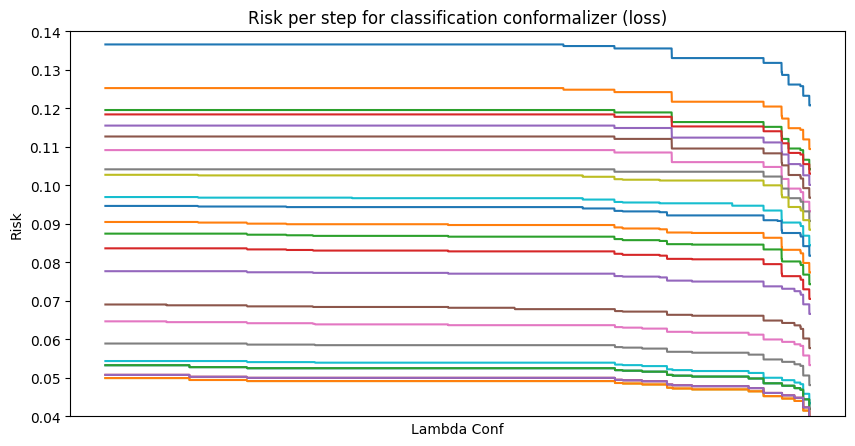

In [19]:
import matplotlib.pyplot as plt

n = len(conf.classification_conformalizer.optimizer2.all_risks_mon)
step = n // 25
# now plot each subpart of length step of the array
plt.figure(figsize=(10, 5))
# Fixed ticks:
plt.xticks(
    [i for i in range(0, n, step)],
    [f"Step {i//step + 1}" for i in range(0, n, step)],
)
# yticks between 0.04 and 0.14
plt.yticks(
    [i / 100 for i in range(4, 15)],
    [f"{i / 100:.2f}" for i in range(4, 15)],
)
plt.ylim(0.04, 0.14)
plt.xlabel("Lambda Conf")
plt.ylabel("Risk")
plt.title("Risk per step for classification conformalizer (loss)")
for i in range(0, n, step):
    plt.plot(
        conf.classification_conformalizer.optimizer2.all_lbds_cnf[i : i + step],
        conf.classification_conformalizer.optimizer2.all_risks_mon[i : i + step],
        label=f"Step {i//step + 1}",
    )
# plt.plot(conf.localization_conformalizer.optimizer2.all_lbds_cnf, conf.localization_conformalizer.optimizer2.all_risks_mon)

Using confidence threshold from preds


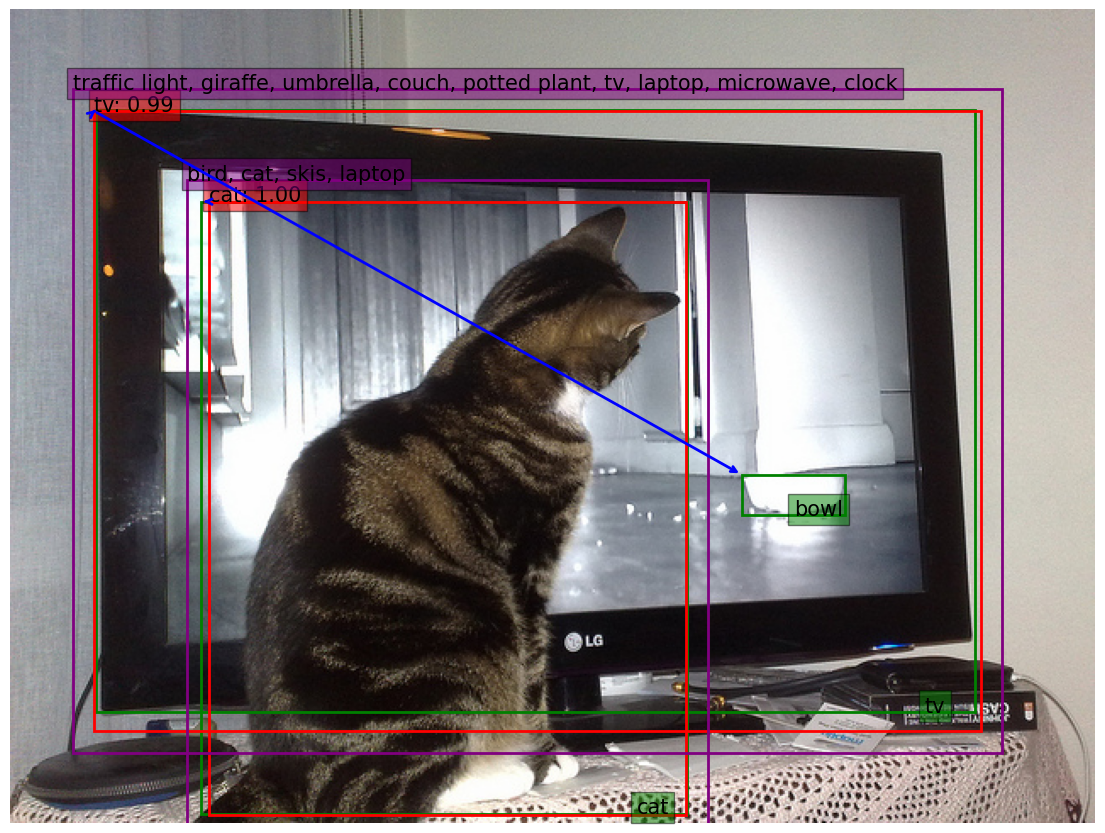

In [11]:
idx = 12
plot_preds(idx, preds_val, conformal_preds, idx_to_label=MSCOCODataset.NAMES)
